<a href="https://colab.research.google.com/github/MRifdaM/SurabayaDev_Asa-Baswara_Data/blob/main/Analisis_Penjualan_HP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning Data

In [ ]:
# 0) IMPORT DAN MOUNT DRIVE
from google.colab import drive
import pandas as pd
import numpy as np
import re

drive.mount('/content/drive')

# 1) LOAD & NORMALISASI NAMA KOLOM
src_path = "/content/drive/MyDrive/SurabayaDev/penjualan_hp.csv" # Pastikan path ini benar
df = pd.read_csv(src_path)

def normalize_colname(c):
    c = str(c).strip().lower()
    c = re.sub(r'[^0-9a-z]+', '_', c)
    c = re.sub(r'_+', '_', c).strip('_')
    return c

df.columns = [normalize_colname(c) for c in df.columns]
print("Shape Awal:", df.shape)
print("Nama Kolom:", list(df.columns))

# 2) PEMETAAN ALIAS KOLOM (FLEKSIBEL TERHADAP NAMA KOLOM)
ALIASES = {
    "order_id": ["order_id", "id_order", "no_order", "invoice_id"],
    "tanggal_pembelian": ["tanggal_pembelian", "tanggal", "tgl_beli", "order_date", "date"],
    "brand": ["merek", "brand", "merk"],
    "produk": ["produk", "product", "tipe", "seri", "model"],
    "harga_satuan": ["harga_satuan", "harga", "price", "unit_price", "harga_per_unit"],
    "jumlah": ["jumlah", "qty", "kuantitas", "quantity"],
    "total_harga": ["total_harga", "total", "total_amount", "amount", "subtotal"],
    "metode_pembayaran": ["metode_pembayaran", "payment_method", "cara_bayar", "metode_bayar"],
    "kota": ["kota", "kota_kabupaten", "city", "kota_pembeli"],
    "status_pengiriman": ["status_pengiriman", "shipping_status", "status_kirim", "status"],
    "rating": ["rating", "penilaian", "skor", "nilai"],
    "nama_pelanggan": ["nama_pelanggan", "customer_name", "nama", "pembeli"]
}

def pick_col(df, ops):
    for o in ops:
        if o in df.columns: return o
    return None

COL = {k: pick_col(df, v) for k, v in ALIASES.items()}

# 3) CASTING TIPE DATA (KONVERSI KE FORMAT YANG BENAR)
def to_float_safe(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    s = re.sub(r'[^\d,.\-]', '', s)
    if ',' in s and '.' in s:
        if s.rfind('.') < s.rfind(','): # Format Eropa: 1.234,56
            s = s.replace('.', '').replace(',', '.')
    elif ',' in s: # Format Indonesia: 1234,56
        s = s.replace(',', '.')
    try:
        return float(s)
    except (ValueError, TypeError):
        return np.nan

for key in ["harga_satuan", "total_harga", "rating"]:
    c = COL.get(key)
    if c: df[c] = df[c].apply(to_float_safe)

if COL.get("jumlah"):
    df[COL["jumlah"]] = pd.to_numeric(df[COL["jumlah"]], errors='coerce').astype('Int64')

if COL.get("tanggal_pembelian"):
    df[COL["tanggal_pembelian"]] = pd.to_datetime(df[COL["tanggal_pembelian"]], errors='coerce')

# 4) STANDARDISASI NILAI KATEGORIKAL (DENGAN PENANGANAN NaN YANG BENAR)
def standardize_text_column(series, mapping=None, case='lower'):
    # Menggunakan np.where untuk menjaga NaN tetap NaN selama operasi string
    s_cleaned = pd.Series(np.where(series.isna(), np.nan, series.astype(str).str.strip()), index=series.index)

    if case == 'lower':
        s_cleaned = s_cleaned.str.lower()
    elif case == 'title':
        s_cleaned = s_cleaned.str.title()
    elif case == 'upper':
        s_cleaned = s_cleaned.str.upper()

    # Hapus teks "Nan" yang mungkin muncul dari konversi NaN ke string
    s_cleaned = s_cleaned.replace('Nan', np.nan)

    if mapping:
        s_cleaned = s_cleaned.replace(mapping)

    return s_cleaned

# Terapkan standardisasi
if COL.get("metode_pembayaran"):
    map_payment = {'cash on delivery': 'cod', 'bayar ditempat': 'cod', 'bayar di tempat': 'cod','transfer bank': 'transfer', 'tf': 'transfer', 'bank transfer': 'transfer','credit card': 'kartukredit', 'kartu kredit': 'kartukredit','ovo': 'e-wallet', 'gopay': 'e-wallet', 'dana': 'e-wallet', 'shopeepay': 'e-wallet'}
    df[COL["metode_pembayaran"]] = standardize_text_column(df[COL["metode_pembayaran"]], map_payment)

if COL.get("status_pengiriman"):
    map_status = {'delivered': 'terkirim', 'success': 'terkirim', 'complete': 'terkirim', 'sukses': 'terkirim','failed': 'gagal', 'cancelled': 'gagal', 'dibatalkan': 'gagal', 'returned': 'gagal','diproses': 'proses', 'processed': 'proses', 'dikirim': 'proses', 'on delivery': 'proses', 'shipping': 'proses'}
    df[COL["status_pengiriman"]] = standardize_text_column(df[COL["status_pengiriman"]], map_status)

if COL.get("brand"):
    df[COL["brand"]] = standardize_text_column(df[COL["brand"]], case='title')

if COL.get("produk"):
    df[COL["produk"]] = standardize_text_column(df[COL["produk"]], case='upper')

if COL.get("kota"):
    s_kota = standardize_text_column(df[COL["kota"]], case='title')
    df[COL["kota"]] = s_kota.str.replace(r'^(Kota|Kab\.?)\s+', '', regex=True)

# 5) IMPUTASI NILAI HILANG (TANPA FLAG)
def impute_num_by_group(df, col, by):
    med_global = df[col].median()
    if by and by in df.columns:
        med_by = df.groupby(by)[col].transform('median')
        df[col] = df[col].fillna(med_by)
    df[col] = df[col].fillna(med_global) # Isi sisa NaN dengan median global
    return df

def impute_cat_by_group(df, col, by, fallback="Unknown"):
    # Hitung mode global sebagai fallback utama
    mode_global = df[col].mode(dropna=True)
    mode_global = mode_global.iloc[0] if not mode_global.empty else fallback

    if by and by in df.columns:
        # Buat peta dari grup 'by' ke nilai mode 'col'
        mode_map = df[df[col].notna()].groupby(by)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        # Gunakan peta untuk mengisi NaN
        df[col] = df[col].fillna(df[by].map(mode_map))

    # Isi sisa NaN (jika grupnya tidak punya mode atau 'by' tidak ada) dengan mode global
    df[col] = df[col].fillna(mode_global)
    return df

brand_col = COL.get("brand")

# a. Imputasi Brand terlebih dahulu (kunci untuk imputasi lain)
if brand_col:
    df = impute_cat_by_group(df, brand_col, by=None, fallback="Unknown")

# b. Imputasi kolom lain menggunakan brand_col yang sudah bersih
for k in ["metode_pembayaran", "status_pengiriman", "kota", "produk"]:
    c = COL.get(k)
    if c: df = impute_cat_by_group(df, c, brand_col)

for k in ["harga_satuan", "total_harga", "jumlah", "rating"]:
    c = COL.get(k)
    if c: df = impute_num_by_group(df, c, brand_col)

# # c. Imputasi Tanggal
# if COL.get("tanggal_pembelian"):
#     c = COL["tanggal_pembelian"]
#     if df[c].notna().any():
#         mode_date = df[c].mode(dropna=True).iloc[0] if not df[c].mode(dropna=True).empty else pd.Timestamp.now().normalize()
#         df[c] = df[c].fillna(mode_date)

# print("\nJumlah NaN setelah imputasi:")
# print(df.isnull().sum())
# c. Imputasi Tanggal dengan Forward Fill dan Backward Fill
if COL.get("tanggal_pembelian"):
    c = COL["tanggal_pembelian"]
    df[c] = pd.to_datetime(df[c], errors='coerce')

    # Ambil hanya tanggal valid yang tidak NaN
    valid_dates = df[c].dropna()

    if len(valid_dates) == 0:
        raise ValueError("❌ Tidak ada tanggal valid yang dapat dijadikan dasar distribusi imputasi.")

    # Hitung distribusi probabilitas dari tanggal yang sudah ada
    tanggal_counts = valid_dates.value_counts(normalize=True).sort_index()

    # Jumlah data yang hilang
    n_missing = df[c].isna().sum()

    print(f"Total baris dengan tanggal kosong: {n_missing}")
    print(f"Rentang tanggal asli: {valid_dates.min().date()} s/d {valid_dates.max().date()}")

    if n_missing > 0:
        # Sampling acak berdasarkan distribusi aktual
        random_dates = np.random.choice(
            tanggal_counts.index,      # daftar tanggal unik
            size=n_missing,           # jumlah tanggal yang dibutuhkan
            p=tanggal_counts.values   # probabilitas distribusi
        )

        # Isi tanggal NaN dengan hasil random
        df.loc[df[c].isna(), c] = random_dates

        print(f"✅ {n_missing} tanggal kosong berhasil diisi menggunakan random berbasis distribusi.")

    else:
        print("Tidak ada data tanggal yang hilang, imputasi tidak diperlukan.")

# 6) KOREKSI LOGIKA HARGA, JUMLAH, DAN TOTAL
price_col = COL.get("harga_satuan")
qty_col   = COL.get("jumlah")
total_col = COL.get("total_harga")
assert price_col and qty_col and total_col, "Pastikan kolom harga_satuan, jumlah, total_harga ada."

# pastikan numerik
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
df[total_col] = pd.to_numeric(df[total_col], errors='coerce')
df[qty_col]   = pd.to_numeric(df[qty_col], errors='coerce').astype('Int64')

TOL = 0.02  # toleransi deviasi 2%

# ---- harga_satuan: imputasi dari total/qty
can_price = df[price_col].isna() & df[qty_col].notna() & (df[qty_col] > 0) & df[total_col].notna()
df.loc[can_price, price_col] = (df.loc[can_price, total_col] / df.loc[can_price, qty_col]).round(0)

# harga teoritis untuk koreksi & outlier
has_both = df[qty_col].notna() & (df[qty_col] > 0) & df[total_col].notna()
harga_teoritis = pd.Series(np.nan, index=df.index)
harga_teoritis.loc[has_both] = (df.loc[has_both, total_col] / df.loc[has_both, qty_col])

implausible_price = df[price_col].isin([1, 9_999_999, 99_999_999, 5_000_000_000, 5000000000]) | (df[price_col] <= 0)
deviasi_besar = (df[price_col].notna() & harga_teoritis.notna() &
                 ((df[price_col] - harga_teoritis).abs() / harga_teoritis.abs() > TOL))

fix_price_mask = (implausible_price | deviasi_besar) & harga_teoritis.notna()
df.loc[fix_price_mask, price_col] = harga_teoritis.loc[fix_price_mask].round(0)

# ---- jumlah: imputasi dari total/harga
qty_was_na_or_bad = df[qty_col].isna() | (df[qty_col] <= 0)
can_qty = qty_was_na_or_bad & df[price_col].notna() & (df[price_col] > 0) & df[total_col].notna()

qty_calc = (df.loc[can_qty, total_col] / df.loc[can_qty, price_col]).round().astype('Int64')
qty_calc = qty_calc.clip(lower=1)

df.loc[can_qty, qty_col] = qty_calc

# pastikan tipe Int64
df[qty_col] = df[qty_col].astype('Int64')

# 7) CAPPING OUTLIER (OPSIONAL, MEMBUAT KOLOM BARU)
def winsorize(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - k*iqr, q3 + k*iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

if price_col: df['harga_satuan_capped'] = df.groupby(brand_col)[price_col].transform(winsorize)
if total_col: df['total_harga_capped'] = df.groupby(brand_col)[total_col].transform(winsorize)
if qty_col:   df['jumlah_capped'] = df.groupby(brand_col)[qty_col].transform(winsorize)


# 8) DROP BARIS DENGAN NAMA PELANGGAN KOSONG
name_col = COL.get("nama_pelanggan")
if name_col:
    mask_empty_name = df[name_col].isna() | df[name_col].astype(str).str.strip().eq('')
    before = len(df)
    df = df.loc[~mask_empty_name].copy()
    print(f"\nDrop baris nama_pelanggan kosong: {before - len(df)} baris dihapus.")

# ==== IMPUTASI order_id: isi kosong dengan nilai sebelumnya + 1 (preserve prefix & zero-pad) ====
order_col = COL.get("order_id")
if not order_col:
    raise KeyError("Kolom 'order_id' tidak ditemukan. Periksa ALIASES untuk order_id.")

# Helper: parse prefix & angka dari sebuah ID, mis. 'ORD00001' -> ('ORD', 1, width=5)
_id_pat = re.compile(r'^([^\d]*)(\d+)$')  # prefix = non-digit (boleh kosong), num = digit (>=1)

def parse_id(x: str):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return (None, None, None)
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return (None, None, None)
    m = _id_pat.match(s)
    if not m:
        return (None, None, None)
    pfx, num_str = m.group(1), m.group(2)
    try:
        num = int(num_str)
    except:
        return (None, None, None)
    return (pfx, num, len(num_str))

def fmt_id(pfx: str, num: int, width: int):
    pfx = "" if pfx is None else pfx
    if width is None or width <= 0:
        return f"{pfx}{num}"
    return f"{pfx}{str(num).zfill(width)}"

# Normalisasi nilai kosong jadi NaN (supaya gampang dideteksi)
ser = df[order_col].astype(str)
ser = ser.where(~ser.str.strip().eq(''), np.nan)
ser = ser.where(~ser.str.lower().eq('nan'), np.nan)

# Iterasi baris demi baris mengikuti urutan df saat ini
last_pfx, last_num, last_width = None, None, None
out_vals = ser.copy()

for i in df.index:  # Iterate through the index of the filtered DataFrame
    val = out_vals.loc[i]  # Use .loc to access by index label
    if pd.isna(val):  # perlu imputasi
        if last_num is not None:  # ada nilai sebelumnya yang valid
            new_num = last_num + 1
            out_vals.loc[i] = fmt_id(last_pfx, new_num, last_width)
            last_num = new_num
        else:
            # kasus khusus: baris pertama kosong & belum ada "sebelumnya"
            last_pfx, last_num, last_width = "ORD", 1, 5
            out_vals.loc[i] = fmt_id(last_pfx, last_num, last_width)
    else:
        # ada nilai -> update "sebelumnya" jika bisa diparse
        pfx, num, width = parse_id(val)
        if num is not None:
            last_pfx, last_num, last_width = pfx, num, width
        else:
            # kalau format tidak bisa diparse, reset sequence
            last_pfx, last_num, last_width = None, None, None

# Tulis balik ke DataFrame
df[order_col] = out_vals

# 9) FINAL SAVE
out_path = "/content/drive/MyDrive/SurabayaDev/penjualan_hp_clean.csv"
df.to_csv(out_path, index=False)
print(f"\n✅ Proses Selesai! Data bersih disimpan ke: {out_path} | Shape Akhir: {df.shape}")
print("\nCek final jumlah NaN:")
print(df.isnull().sum())
print("\nContoh 5 baris data bersih:")
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape Awal: (1575, 12)
Nama Kolom: ['order_id', 'tanggal_pembelian', 'nama_pelanggan', 'kota', 'produk', 'merek', 'harga_satuan', 'jumlah', 'total_harga', 'metode_pembayaran', 'rating', 'status_pengiriman']
Total baris dengan tanggal kosong: 1209
Rentang tanggal asli: 2025-01-24 s/d 2025-07-25
✅ 1209 tanggal kosong berhasil diisi menggunakan random berbasis distribusi.

Drop baris nama_pelanggan kosong: 61 baris dihapus.

✅ Proses Selesai! Data bersih disimpan ke: /content/drive/MyDrive/SurabayaDev/penjualan_hp_clean.csv | Shape Akhir: (1514, 15)

Cek final jumlah NaN:
order_id               0
tanggal_pembelian      0
nama_pelanggan         0
kota                   0
produk                 0
merek                  0
harga_satuan           0
jumlah                 0
total_harga            0
metode_pembayaran      0
rating                 0
status_pengiriman   

,order_id,tanggal_pembelian,nama_pelanggan,kota,produk,merek,harga_satuan,jumlah,total_harga,metode_pembayaran,rating,status_pengiriman,harga_satuan_capped,total_harga_capped,jumlah_capped
0,ORD00001,2025-02-28,"Tgk. Eli Narpati, S.IP",Gorontalo,IPHONE 13,Apple,9443827.0,1,9443827.0,transfer,4.0,terkirim,9443827.0,9443827.0,1
1,ORD00002,2025-03-03,Hendra Pratiwi,Salatiga,VIVO V29,Vivo,8682500.0,1,8682500.0,kartukredit,4.0,dalam pengiriman,8682500.0,8682500.0,1
2,ORD00003,2025-04-24,"Tami Iswahyudi, S.Kom",Tual,REALME C55,Realme,6183710.0,1,6183710.0,transfer,1.0,terkirim,6183710.0,6183710.0,1
3,ORD00004,2025-07-21,Rafid Saputra,Binjai,VIVO Y27,Vivo,13747665.0,1,13747665.0,cod,3.0,terkirim,13747665.0,13747665.0,1
5,ORD00006,2025-03-15,T. Mariadi Hidayat,Depok,VIVO Y27,Vivo,13747665.0,1,13747665.0,e-wallet,3.0,terkirim,13747665.0,13747665.0,1


In [ ]:
# === Download langsung dari Colab ke komputer Anda ===
from google.colab import files
files.download(out_path)  # out_path = "/content/drive/MyDrive/SurabayaDev/penjualan_hp_clean.csv"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Feature Engineering

In [ ]:

from google.colab import drive
import pandas as pd, numpy as np, re, os

# 0) Mount Drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 1) Path file input/output di Drive
IN_PATH  = "/content/drive/MyDrive/SurabayaDev/penjualan_hp_clean.csv"   # <-- ganti kalau perlu
OUT_PATH = "/content/drive/MyDrive/SurabayaDev/penjualan_hp_transformed.csv"
OUT_SKU_MONTHLY   = "/content/drive/MyDrive/SurabayaDev/sku_monthly.csv"
OUT_BRAND_MONTHLY = "/content/drive/MyDrive/SurabayaDev/brand_monthly.csv"
OUT_SHIP_MONTHLY  = "/content/drive/MyDrive/SurabayaDev/ship_monthly.csv"

# 2) Load
df = pd.read_csv(IN_PATH)
print(f"✅ Loaded: {IN_PATH} | shape={df.shape}")

# 3) Normalisasi nama kolom
def normalize_colname(c):
    c = str(c).strip().lower()
    c = re.sub(r'[^0-9a-z]+','_', c)
    c = re.sub(r'_+','_', c).strip('_')
    return c
df.columns = [normalize_colname(c) for c in df.columns]

# 4) Pemetaan alias → COL
ALIASES = {
    "order_id": ["order_id","id_order","no_order","invoice_id"],
    "tanggal_pembelian": ["tanggal_pembelian","tanggal","tgl_beli","order_date","date"],
    "brand": ["merek","brand","merk"],
    "produk": ["produk","product","tipe","seri","model"],
    "harga_satuan": ["harga_satuan","harga","price","unit_price","harga_per_unit"],
    "jumlah": ["jumlah","qty","kuantitas","quantity"],
    "total_harga": ["total_harga","total","total_amount","amount","subtotal"],
    "metode_pembayaran": ["metode_pembayaran","payment_method","cara_bayar","metode_bayar"],
    "kota": ["kota","kota_kabupaten","city","kota_pembeli"],
    "status_pengiriman": ["status_pengiriman","shipping_status","status_kirim","status"],
    "rating": ["rating","penilaian","skor","nilai"],
}
def pick_col(df_, ops):
    for o in ops:
        if o in df_.columns: return o
    return None
COL = {k: pick_col(df, v) for k,v in ALIASES.items()}

# 5) Pastikan tipe kolom kunci
dt_col    = COL.get("tanggal_pembelian")
price_col = COL.get("harga_satuan")
qty_col   = COL.get("jumlah")
total_col = COL.get("total_harga")
brand_col = COL.get("brand")
prod_col  = COL.get("produk")
pay_col   = COL.get("metode_pembayaran")
city_col  = COL.get("kota")
ship_col  = COL.get("status_pengiriman")
rate_col  = COL.get("rating")

missing  = [name for name in ["tanggal_pembelian","harga_satuan","jumlah","total_harga","brand","produk"] if COL.get(name) is None]
if missing:
    raise KeyError(f"Kolom wajib belum terdeteksi: {missing}. Cek kembali header CSV.")

df[dt_col]    = pd.to_datetime(df[dt_col], errors="coerce")
df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
df[total_col] = pd.to_numeric(df[total_col], errors="coerce")
df[qty_col]   = pd.to_numeric(df[qty_col], errors="coerce").astype("Int64")

# 6) SKU
df["sku"] = (df[brand_col].astype(str).str.strip() + " " + df[prod_col].astype(str).str.strip()).str.strip()

# 7) Fitur waktu
df["year"]    = df[dt_col].dt.year
df["month"]   = df[dt_col].dt.month
df["ym"]      = df[dt_col].dt.to_period("M").astype(str)   # 'YYYY-MM'
df["quarter"] = df[dt_col].dt.quarter
df["dow"]     = df[dt_col].dt.dayofweek                    # 0=Mon
df["bulan_pembelian"] = df[dt_col].dt.strftime("%B")
df["hari_pembelian"]  = df[dt_col].dt.strftime("%A")

# 8) Harga efektif & diskon implisit
TOL = 0.02
df["unit_price_effective"] = (df[total_col] / df[qty_col]).replace([np.inf,-np.inf], np.nan)
df["delta_unit_price"]     = df["unit_price_effective"] - df[price_col]
base = (df[price_col] * df[qty_col]).replace(0, np.nan)
rel_diff = (base - df[total_col]) / base
df["dapat_diskon"] = rel_diff.gt(0.01)   # >1% → diskon

# diskon relatif thd median SKU
sku_median = df.groupby("sku")["unit_price_effective"].transform("median")
df["discount_ratio_vs_sku_median"] = 1 - (df["unit_price_effective"] / sku_median)

# 9) Bucket harga (qcut; fallback cut)
basis_price = df["unit_price_effective"].where(df["unit_price_effective"].notna(), df[price_col])
try:
    df["harga_bucket"] = pd.qcut(basis_price, q=3, labels=["low","mid","high"])
except ValueError:
    bins = [-np.inf, basis_price.median(), basis_price.quantile(0.9), np.inf]
    df["harga_bucket"] = pd.cut(basis_price, bins=bins, labels=["low","mid","high"])

# (opsional) bucket per brand
try:
    df["harga_bucket_brand"] = (
        df.groupby(brand_col)["unit_price_effective"]
          .transform(lambda s: pd.qcut(s, q=3, labels=["low","mid","high"]))
    )
except Exception:
    df["harga_bucket_brand"] = df["harga_bucket"]

# 10) Payment safety level
if pay_col:
    safety_map = {"cod":3, "e-wallet":2, "kartukredit":2, "transfer":1}
    df["payment_safety_level"] = df[pay_col].map(safety_map).fillna(1).astype(int)

# 11) Flags kualitas rating vs status
if rate_col:
    df["rating_high"] = (pd.to_numeric(df[rate_col], errors="coerce") >= 4).astype(int)
if rate_col and ship_col:
    df["rating_v_status_mismatch"] = ((df[ship_col] == "gagal") &
                                      (pd.to_numeric(df[rate_col], errors="coerce") >= 4)).astype(int)

# 12) Agregat cache
# a) per SKU bulanan
sku_monthly = (df.groupby(["ym","sku"], as_index=False)
                 .agg(qty=(qty_col,"sum"), revenue=(total_col,"sum")))

# b) per brand bulanan
brand_monthly = (df.groupby(["ym",brand_col], as_index=False)
                   .agg(qty=(qty_col,"sum"), revenue=(total_col,"sum")))

# c) status kirim rate per bulan (PERBAIKAN: tanpa reset_index duplikat kolom)
if ship_col:
    ship_counts = (df.groupby(['ym', ship_col], as_index=False)
                     .size()
                     .rename(columns={'size': 'count'}))
    ship_counts['rate'] = (ship_counts['count'] /
                           ship_counts.groupby('ym')['count'].transform('sum')).round(4)
    ship_monthly = ship_counts[['ym', ship_col, 'rate']]
else:
    ship_monthly = pd.DataFrame()

# 13) Kota utilitas (Top-10)
if city_col:
    top_cities = set(df[city_col].value_counts().head(10).index)
    df["is_top_city"] = df[city_col].apply(lambda x: "Top" if x in top_cities else "Other")

# 14) Save ke Drive
df.to_csv(OUT_PATH, index=False)
sku_monthly.to_csv(OUT_SKU_MONTHLY, index=False)
brand_monthly.to_csv(OUT_BRAND_MONTHLY, index=False)
if not ship_monthly.empty:
    ship_monthly.to_csv(OUT_SHIP_MONTHLY, index=False)

print("✅ Transform selesai & tersimpan:")
print(" -", OUT_PATH)
print(" -", OUT_SKU_MONTHLY)
print(" -", OUT_BRAND_MONTHLY)
if not ship_monthly.empty:
    print(" -", OUT_SHIP_MONTHLY)

# 15) Preview
print("\nPreview kolom kunci:")
show_cols = [dt_col, "ym", brand_col, prod_col, "sku",
             price_col, "unit_price_effective", "harga_bucket",
             qty_col, total_col, "dapat_diskon"]
show_cols = [c for c in show_cols if c in df.columns]
display(df[show_cols].head(10))


✅ Loaded: /content/drive/MyDrive/SurabayaDev/penjualan_hp_clean.csv | shape=(1514, 15)
✅ Transform selesai & tersimpan:
 - /content/drive/MyDrive/SurabayaDev/penjualan_hp_transformed.csv
 - /content/drive/MyDrive/SurabayaDev/sku_monthly.csv
 - /content/drive/MyDrive/SurabayaDev/brand_monthly.csv
 - /content/drive/MyDrive/SurabayaDev/ship_monthly.csv

Preview kolom kunci:


,tanggal_pembelian,ym,merek,produk,sku,harga_satuan,unit_price_effective,harga_bucket,jumlah,total_harga,dapat_diskon
0,2025-02-28,2025-02,Apple,IPHONE 13,Apple IPHONE 13,9443827.0,9443827.0,mid,1,9443827.0,False
1,2025-03-03,2025-03,Vivo,VIVO V29,Vivo VIVO V29,8682500.0,8682500.0,low,1,8682500.0,False
2,2025-04-24,2025-04,Realme,REALME C55,Realme REALME C55,6183710.0,6183710.0,low,1,6183710.0,False
3,2025-07-21,2025-07,Vivo,VIVO Y27,Vivo VIVO Y27,13747665.0,13747665.0,mid,1,13747665.0,False
4,2025-03-15,2025-03,Vivo,VIVO Y27,Vivo VIVO Y27,13747665.0,13747665.0,mid,1,13747665.0,False
5,2025-05-07,2025-05,Apple,IPHONE 14 PRO,Apple IPHONE 14 PRO,9443827.0,9443827.0,mid,1,9443827.0,False
6,2025-04-21,2025-04,Samsung,GALAXY S23,Samsung GALAXY S23,5131304.0,5131304.0,low,1,5131304.0,False
7,2025-07-01,2025-07,Apple,OPPO RENO10,Apple OPPO RENO10,16139773.0,16139773.0,high,2,32279546.0,False
8,2025-07-10,2025-07,Samsung,GALAXY A14,Samsung GALAXY A14,15965299.0,15965299.0,high,2,31930598.0,False
9,2025-03-04,2025-03,Oppo,OPPO RENO10,Oppo OPPO RENO10,16139773.0,16139773.0,high,2,32279546.0,False


In [ ]:
# === Download langsung dari Colab ke komputer (cara A) ===
from google.colab import files
import os

# daftar file yang ingin diunduh
to_download = [OUT_PATH, OUT_SKU_MONTHLY, OUT_BRAND_MONTHLY]
if not ship_monthly.empty:
    to_download.append(OUT_SHIP_MONTHLY)

for p in to_download:
    if os.path.exists(p):
        print(f"Mengunduh: {p}")
        files.download(p)
    else:
        print(f"⚠️ File tidak ditemukan, lewati: {p}")


Mengunduh: /content/drive/MyDrive/SurabayaDev/penjualan_hp_transformed.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mengunduh: /content/drive/MyDrive/SurabayaDev/sku_monthly.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mengunduh: /content/drive/MyDrive/SurabayaDev/brand_monthly.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mengunduh: /content/drive/MyDrive/SurabayaDev/ship_monthly.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#EDA


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Load data bersih hasil feature engineering
df_eda = pd.read_csv("/content/drive/MyDrive/SurabayaDev/penjualan_hp_transformed.csv")

# Preview awal
df_eda.head()

,order_id,tanggal_pembelian,nama_pelanggan,kota,produk,merek,harga_satuan,jumlah,total_harga,metode_pembayaran,...,unit_price_effective,delta_unit_price,dapat_diskon,discount_ratio_vs_sku_median,harga_bucket,harga_bucket_brand,payment_safety_level,rating_high,rating_v_status_mismatch,is_top_city
0,ORD00001,2025-02-28,"Tgk. Eli Narpati, S.IP",Gorontalo,IPHONE 13,Apple,9443827.0,1,9443827.0,transfer,...,9443827.0,0.0,False,0.173413,mid,low,1,1,0,Other
1,ORD00002,2025-03-10,Hendra Pratiwi,Salatiga,VIVO V29,Vivo,8682500.0,1,8682500.0,kartukredit,...,8682500.0,0.0,False,0.000000,low,low,2,1,0,Top
2,ORD00003,2025-03-10,"Tami Iswahyudi, S.Kom",Tual,REALME C55,Realme,6183710.0,1,6183710.0,transfer,...,6183710.0,0.0,False,0.000000,low,mid,1,0,0,Other
3,ORD00004,2025-03-10,Rafid Saputra,Binjai,VIVO Y27,Vivo,13747665.0,1,13747665.0,cod,...,13747665.0,0.0,False,0.000000,mid,mid,3,0,0,Other
4,ORD00006,2025-03-10,T. Mariadi Hidayat,Depok,VIVO Y27,Vivo,13747665.0,1,13747665.0,e-wallet,...,13747665.0,0.0,False,0.000000,mid,mid,2,0,0,Other


#Memastikan Kolom Penting Ada
Kolom penting yang wajib ada:

sku → identitas unik HP (gabungan merek + tipe)

merek → nama merek

jumlah → unit terjual

total_harga → total penjualan

In [17]:
#memastikan kolom penting ada semua
required_cols = ['sku', 'merek', 'jumlah', 'total_harga']
missing_cols = [col for col in required_cols if col not in df_eda.columns]

if missing_cols:
    raise KeyError(f"Kolom berikut belum ada dalam dataset: {missing_cols}")


#Statistik Deskriptif

In [18]:
#Statistik Deskriptif
print("Jumlah baris data:", len(df_eda))

# Statistik deskriptif untuk jumlah unit dan total harga
print("\nRingkasan statistik kolom numerik:")
print(df_eda[['jumlah', 'total_harga']].describe())

# Cek jumlah data kosong
print("\nJumlah data kosong per kolom penting:")
print(df_eda[required_cols].isnull().sum())


Jumlah baris data: 1514

Ringkasan statistik kolom numerik:
            jumlah   total_harga
count  1514.000000  1.514000e+03
mean      1.990092  2.099120e+07
std       0.783526  1.286080e+07
min       1.000000  1.743334e+06
25%       1.000000  1.142508e+07
50%       2.000000  1.852775e+07
75%       3.000000  2.833148e+07
max       3.000000  4.841932e+07

Jumlah data kosong per kolom penting:
sku            0
merek          0
jumlah         0
total_harga    0
dtype: int64


#Agregasi Penjualan per SKU

In [19]:
#Agregasi penjualan per SKU
sku_sales = (
    df_eda.groupby('sku', as_index=False)
    .agg(total_unit=('jumlah', 'sum'),
         total_revenue=('total_harga', 'sum'))
    .sort_values(by='total_unit', ascending=False)
)

# Preview 10 teratas
sku_sales.head(10)


,sku,total_unit,total_revenue
2,Apple IPHONE 13,284,3.194729e+09
12,Oppo OPPO A57,284,3.878170e+09
14,Realme REALME 11 PRO,267,4.875080e+08
13,Oppo OPPO RENO10,258,4.097332e+09
17,Samsung GALAXY S23,257,1.468136e+09
3,Apple IPHONE 14 PRO,248,2.332625e+09
15,Realme REALME C55,245,1.479322e+09
21,Xiaomi REDMI NOTE 12,242,3.722961e+09
19,Vivo VIVO Y27,238,3.225632e+09
16,Samsung GALAXY A14,233,3.669733e+09


#Tren Bulanan SKU Terlaris

10 SKU terlaris: ['Apple IPHONE 13', 'Oppo OPPO A57', 'Realme REALME 11 PRO', 'Oppo OPPO RENO10', 'Samsung GALAXY S23', 'Apple IPHONE 14 PRO', 'Realme REALME C55', 'Xiaomi REDMI NOTE 12', 'Vivo VIVO Y27', 'Samsung GALAXY A14']


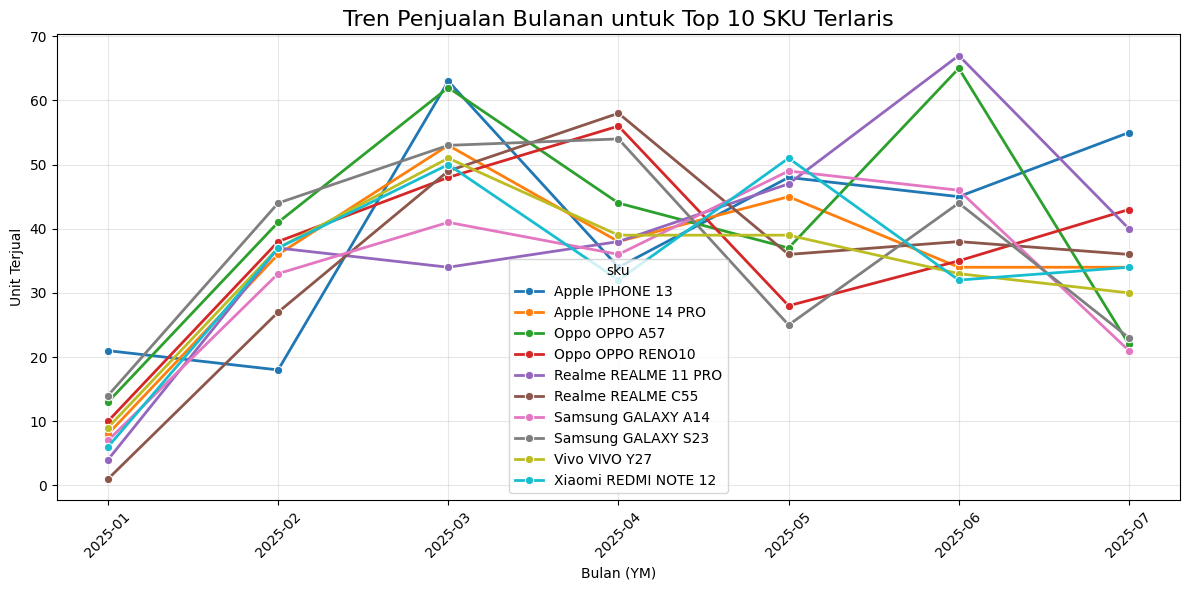

,ym,sku,jumlah
0,2025-01,Apple IPHONE 13,21
1,2025-01,Apple IPHONE 14 PRO,8
2,2025-01,Oppo OPPO A57,13
3,2025-01,Oppo OPPO RENO10,10
4,2025-01,Realme REALME 11 PRO,4


In [ ]:
# Ambil 10 SKU paling laris
top_10_sku = sku_sales.head(10)['sku'].tolist()
print(f"10 SKU terlaris: {top_10_sku}")

# Filter data hanya untuk 10 SKU terlaris
df_top_10_sku = df_eda[df_eda['sku'].isin(top_10_sku)]

# Agregasi bulanan per SKU
trend_top_10_sku = (
    df_top_10_sku.groupby(['ym', 'sku'], as_index=False)['jumlah']
    .sum()
    .sort_values('ym')
)

# Visualisasi tren multi-garis
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_top_10_sku, x='ym', y='jumlah', hue='sku', marker='o', linewidth=2)

plt.title("Tren Penjualan Bulanan untuk Top 10 SKU Terlaris", fontsize=16)
plt.xlabel("Bulan (YM)")
plt.ylabel("Unit Terjual")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

trend_top_10_sku.head()

#Tren Bulanan Merek Terlaris



5 Merek terlaris: ['Apple', 'Oppo', 'Realme', 'Samsung', 'Xiaomi']


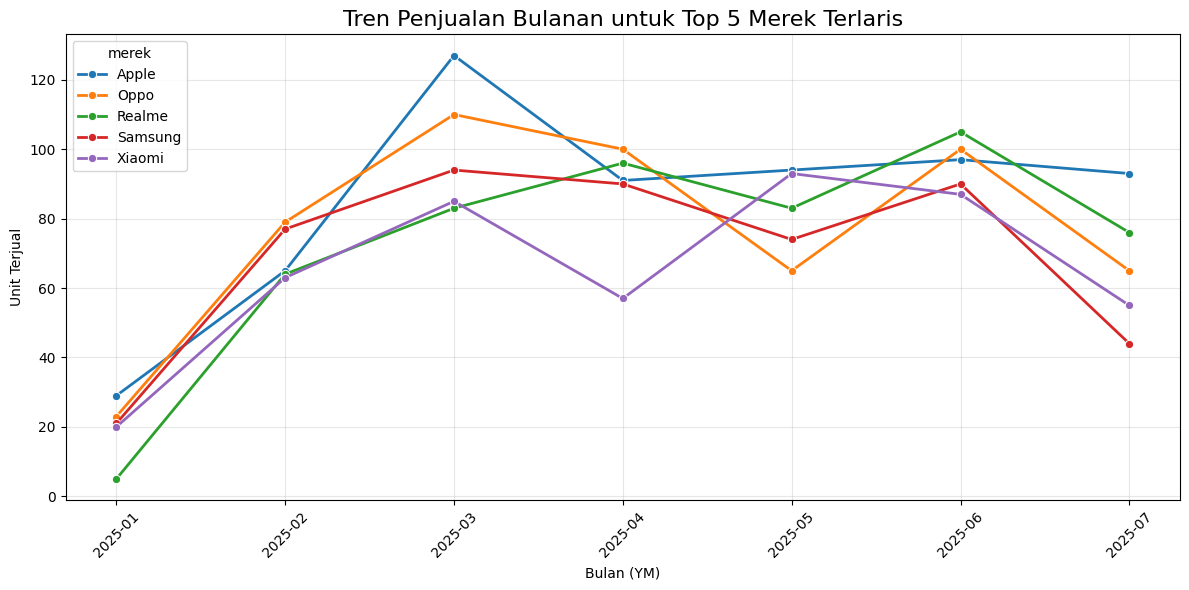

,ym,merek,jumlah
0,2025-01,Apple,29
1,2025-01,Oppo,23
2,2025-01,Realme,5
3,2025-01,Samsung,21
4,2025-01,Xiaomi,20


In [ ]:
# Ambil 5 merek paling laris
top_5_merek = merek_sales.head(5)['merek'].tolist()
print(f"5 Merek terlaris: {top_5_merek}")

# Filter data hanya untuk 5 merek terlaris
df_top_5_merek = df_eda[df_eda['merek'].isin(top_5_merek)]

# Agregasi bulanan per merek
trend_top_5_merek = (
    df_top_5_merek.groupby(['ym', 'merek'], as_index=False)['jumlah']
    .sum()
    .sort_values('ym')
)

# Visualisasi tren multi-garis
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_top_5_merek, x='ym', y='jumlah', hue='merek', marker='o', linewidth=2)

plt.title("Tren Penjualan Bulanan untuk Top 5 Merek Terlaris", fontsize=16)
plt.xlabel("Bulan (YM)")
plt.ylabel("Unit Terjual")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

trend_top_5_merek.head()

#Hubungan HP Terlaris dengan Harga

Batas Harga Standar Pasar:
 - Entry Level : < Rp 3,000,000
 - Mid Range   : Rp 3,000,000 s/d Rp 8,000,000
 - High End    : > Rp 8,000,000


/tmp/ipython-input-808233341.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_sku.loc[:, 'harga_bucket'] = top_10_sku['avg_price'].apply(categorize_price_standard)


,sku,total_unit,avg_price,harga_bucket
2,Apple IPHONE 13,284,1.135568e+07,High End
12,Oppo OPPO A57,284,1.378667e+07,High End
14,Realme REALME 11 PRO,267,1.835705e+06,Entry Level
13,Oppo OPPO RENO10,258,1.602060e+07,High End
17,Samsung GALAXY S23,257,5.890124e+06,Mid Range
3,Apple IPHONE 14 PRO,248,9.405123e+06,High End
15,Realme REALME C55,245,6.052814e+06,Mid Range
21,Xiaomi REDMI NOTE 12,242,1.553722e+07,High End
19,Vivo VIVO Y27,238,1.364815e+07,High End
16,Samsung GALAXY A14,233,1.578454e+07,High End


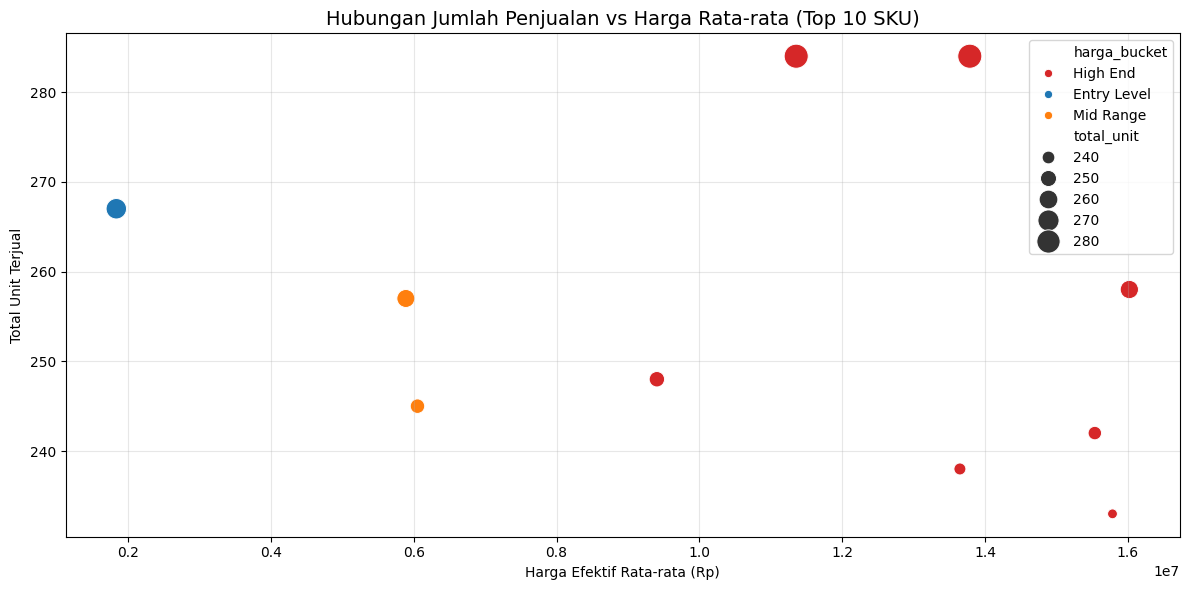

In [ ]:
# --- Step A: Identifikasi 10 SKU Paling Laris ---
sku_summary = (
    df_eda.groupby('sku', as_index=False)
    .agg(
        total_unit=('jumlah', 'sum'),                  # Total unit terjual
        avg_price=('unit_price_effective', 'mean')     # Rata-rata harga satuan
    )
    .sort_values(by='total_unit', ascending=False)
)

# Ambil 10 SKU teratas
top_10_sku = sku_summary.head(10)

# --- Step B: Batas Harga Berdasarkan Standar Pasar ---
# Menentukan segmentasi pasar smartphone Indonesia
ENTRY_MAX = 3_000_000      # < 3 juta = Entry Level
MID_MAX = 8_000_000        # 3 - 8 juta = Mid Range
# > 8 juta = High End

print(f"Batas Harga Standar Pasar:")
print(f" - Entry Level : < Rp {ENTRY_MAX:,.0f}")
print(f" - Mid Range   : Rp {ENTRY_MAX:,.0f} s/d Rp {MID_MAX:,.0f}")
print(f" - High End    : > Rp {MID_MAX:,.0f}")

# --- Step C: Assign Bucket Harga Menggunakan Standar Pasar ---
def categorize_price_standard(price):
    if price < ENTRY_MAX:
        return 'Entry Level'
    elif price <= MID_MAX:
        return 'Mid Range'
    else:
        return 'High End'

# Gunakan .loc untuk menghindari SettingWithCopyWarning
top_10_sku.loc[:, 'harga_bucket'] = top_10_sku['avg_price'].apply(categorize_price_standard)

# Preview hasil pembagian bucket
display(top_10_sku[['sku', 'total_unit', 'avg_price', 'harga_bucket']])

# --- Step D: Visualisasi Scatterplot Hubungan Harga vs Penjualan ---
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=top_10_sku,
    x='avg_price',
    y='total_unit',
    hue='harga_bucket',   # Warna berdasarkan kategori yang jelas
    size='total_unit',
    palette={
        'Entry Level':'#1f77b4',
        'Mid Range':'#ff7f0e',
        'High End':'#d62728'
    },
    sizes=(50, 300)
)
plt.title("Hubungan Jumlah Penjualan vs Harga Rata-rata (Top 10 SKU)", fontsize=14)
plt.xlabel("Harga Efektif Rata-rata (Rp)")
plt.ylabel("Total Unit Terjual")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#Boxplot Analisis Distribusi & Outlier



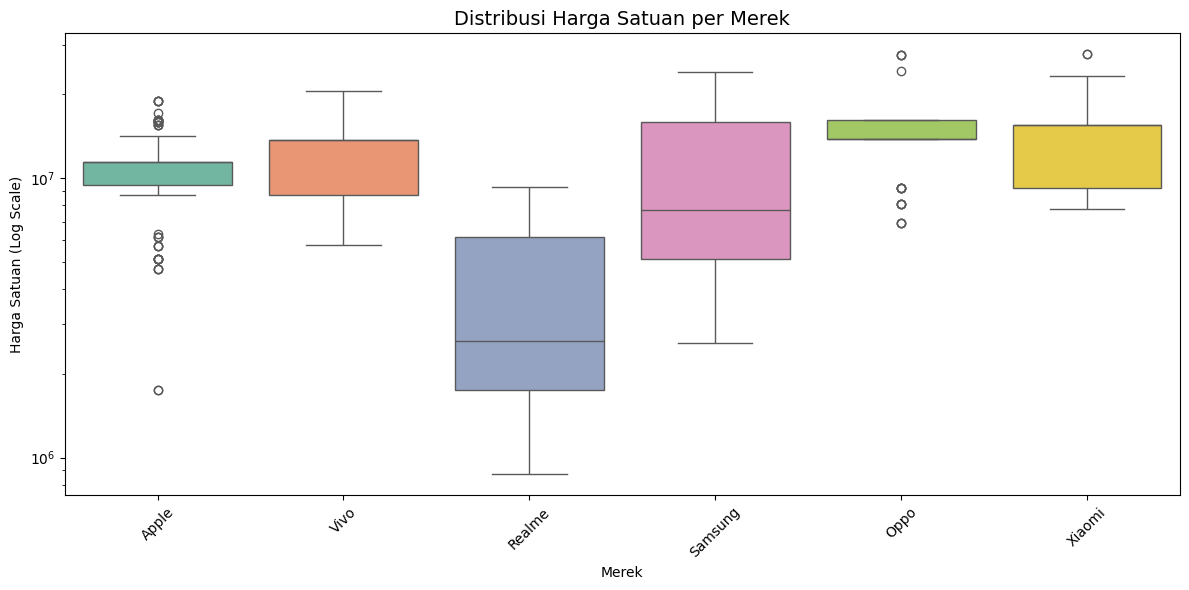

In [ ]:
# Boxplot Harga Satuan per Merek
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_eda,
    x='merek',
    y='unit_price_effective',
    hue='merek',
    palette='Set2',
    legend=False
)
plt.yscale('log')  # gunakan skala log untuk harga
plt.title("Distribusi Harga Satuan per Merek", fontsize=14)
plt.xlabel("Merek")
plt.ylabel("Harga Satuan (Log Scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Hubungan antar variabel numerik dengan Heatmap

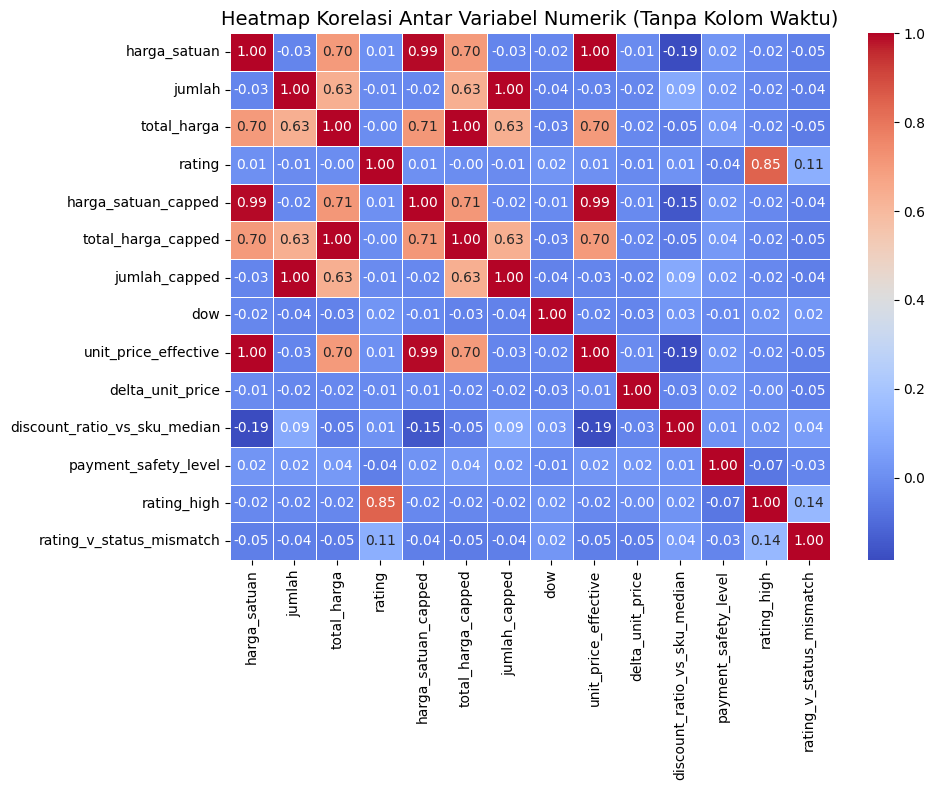

In [ ]:
# Pilih hanya kolom numerik
df_numeric = df_eda.select_dtypes(include=['int64', 'float64'])

# Hapus kolom terkait waktu jika ada
time_columns = ['year', 'month', 'quarter']  # tambahkan jika ada kolom lain
df_numeric = df_numeric.drop(columns=[col for col in time_columns if col in df_numeric.columns])

# Hitung korelasi antar variabel numerik
corr = df_numeric.corr()

# Visualisasi heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title("Heatmap Korelasi Antar Variabel Numerik (Tanpa Kolom Waktu)", fontsize=14)
plt.tight_layout()
plt.show()


#Hubungan kota dengan status pengiriman

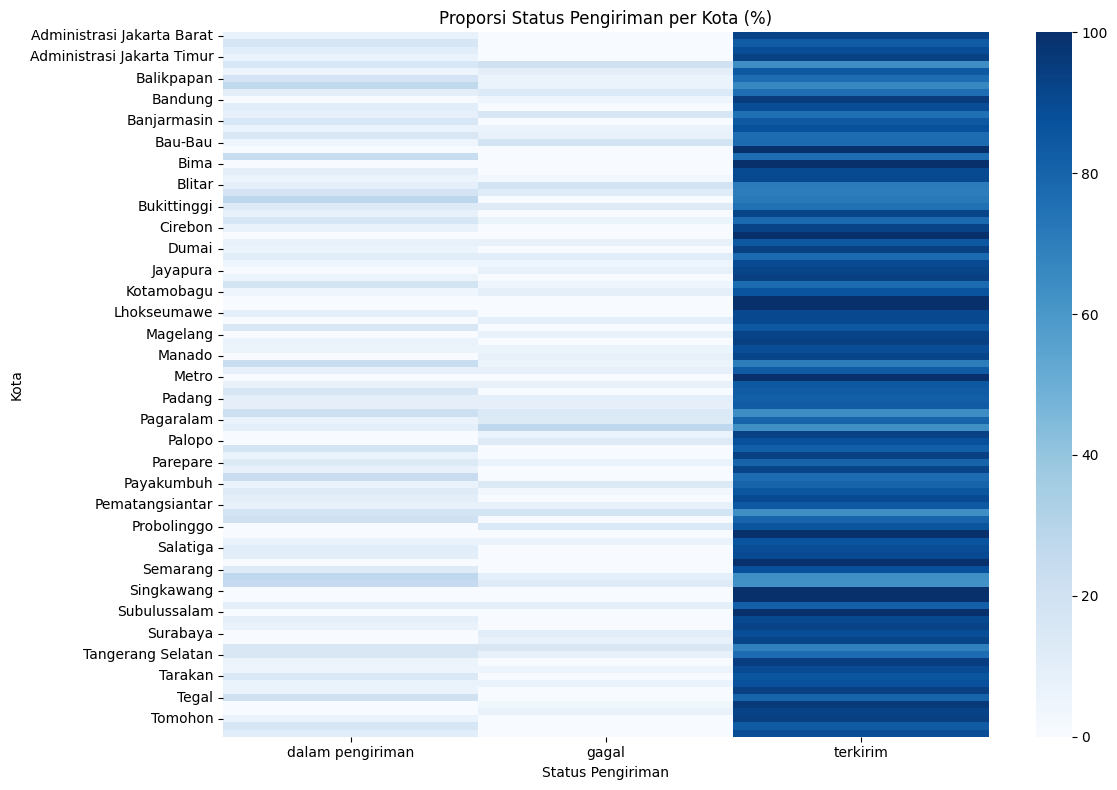

=== Top 10 Kota dengan Persentase Gagal Tertinggi ===


,persen_gagal
kota,
Palangkaraya,27.272727
Administrasi Jakarta Utara,20.000000
Blitar,19.047619
Pontianak,18.181818
Bau-Bau,18.181818
Banjarbaru,16.666667
Tangerang,15.384615
Padangpanjang,14.285714
Probolinggo,14.285714


In [47]:
# 10. Hubungan kota x status_pengiriman (proporsi per kota)

ct = pd.crosstab(df_eda['kota'], df_eda['status_pengiriman'], normalize='index') * 100
plt.figure(figsize=(12,8))
sns.heatmap(ct, annot=False, cmap='Blues')
plt.title('Proporsi Status Pengiriman per Kota (%)')
plt.xlabel('Status Pengiriman')
plt.ylabel('Kota')
plt.tight_layout()
plt.show()

# Top kota dengan tingkat 'gagal' tertinggi (untuk insight cepat)
gagal_top = ct['gagal'].sort_values(ascending=False).head(10)
print("=== Top 10 Kota dengan Persentase Gagal Tertinggi ===")
display(gagal_top.to_frame('persen_gagal'))


#Apakah rating dan status pengiriman memiliki keterkaitan? (mis. gagal tapi rating 5)

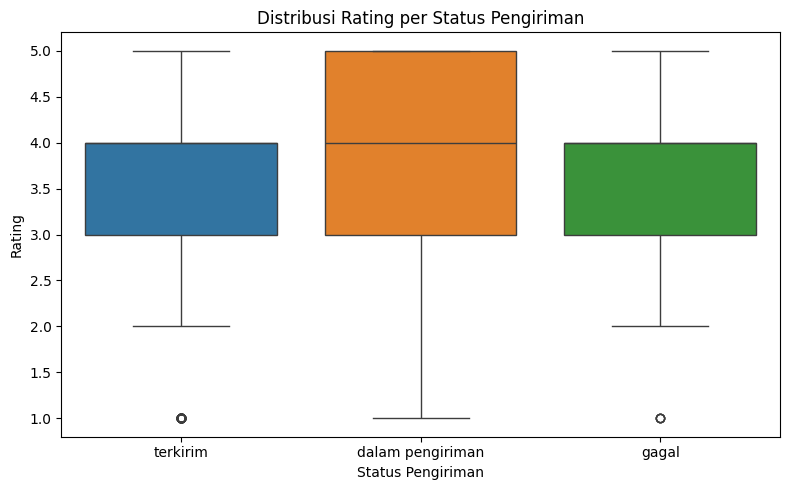

Jumlah anomali (gagal tapi rating >=4.5): 15


,order_id,kota,merek,produk,rating
124,ORD00131,Banjarbaru,Realme,REALME C55,5.0
230,ORD00243,Ternate,Realme,REALME C55,5.0
394,ORD00412,Batu,Realme,REALME C55,5.0
548,ORD00571,Sibolga,Samsung,GALAXY A14,5.0
552,ORD00575,Blitar,Realme,REALME 11 PRO,5.0
596,ORD00620,Probolinggo,Samsung,GALAXY S23,5.0
694,ORD00719,Parepare,Realme,REALME 11 PRO,5.0
901,ORD00935,Banda Aceh,Apple,IPHONE 13,5.0
909,ORD00944,Manado,Realme,REALME 11 PRO,5.0
952,ORD00988,Pagaralam,Xiaomi,POCO X5,5.0


Spearman corr(rating vs is_terkirim): -0.018


In [ ]:
# 14. Keterkaitan rating vs status_pengiriman
# a) Boxplot rating per status (jika rating ada untuk semua status)
plt.figure(figsize=(8,5))
sns.boxplot(data=df_eda.dropna(subset=['rating']), x='status_pengiriman', y='rating', hue='status_pengiriman', legend=False)
plt.title('Distribusi Rating per Status Pengiriman')
plt.xlabel('Status Pengiriman')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# b) Deteksi anomali: status gagal tapi rating tinggi (>=4.5)
anom = df_eda[(df_eda['status_pengiriman'] == 'gagal') & (df_eda['rating'] >= 4.5)]
print(f"Jumlah anomali (gagal tapi rating >=4.5): {len(anom)}")
if len(anom) > 0:
    display(anom[['order_id' if 'order_id' in df_eda.columns else df_eda.columns[0], 'kota','merek','produk','rating']].head(20))

# c) Korelasi sederhana (Spearman) antara rating dan indikator terkirim (1)/lainnya(0)
df_corr_tmp = df_eda.dropna(subset=['rating']).copy()
df_corr_tmp['is_terkirim'] = (df_corr_tmp['status_pengiriman'] == 'terkirim').astype(int)
spearman_corr = df_corr_tmp[['rating','is_terkirim']].corr(method='spearman').iloc[0,1]
print(f"Spearman corr(rating vs is_terkirim): {spearman_corr:.3f}")


# KPI Utama

In [92]:
total_penjualan = df["total_harga_capped"].sum()
total_unit = df["jumlah_capped"].sum()
total_transaksi = df["order_id"].nunique()
rata_rating = df["rating"].mean()
persen_diskon = df["dapat_diskon"].mean() * 100

print("KPI Utama")
print(f"Total Penjualan     : Rp {total_penjualan:,.0f}")
print(f"Unit Terjual        : {total_unit}")
print(f"Jumlah Transaksi    : {total_transaksi}")
print(f"Rata-rata Rating    : {rata_rating:.2f}")
print(f"% Transaksi Diskon  : {persen_diskon:.2f}%")

KPI Utama
Total Penjualan     : Rp 31,780,676,420
Unit Terjual        : 3013
Jumlah Transaksi    : 1442
Rata-rata Rating    : 3.66
% Transaksi Diskon  : 0.00%


# Visualisasi Data

# Analisis Top 10 HP Paling Laris Berdasarkan Jumlah Unit Terjual

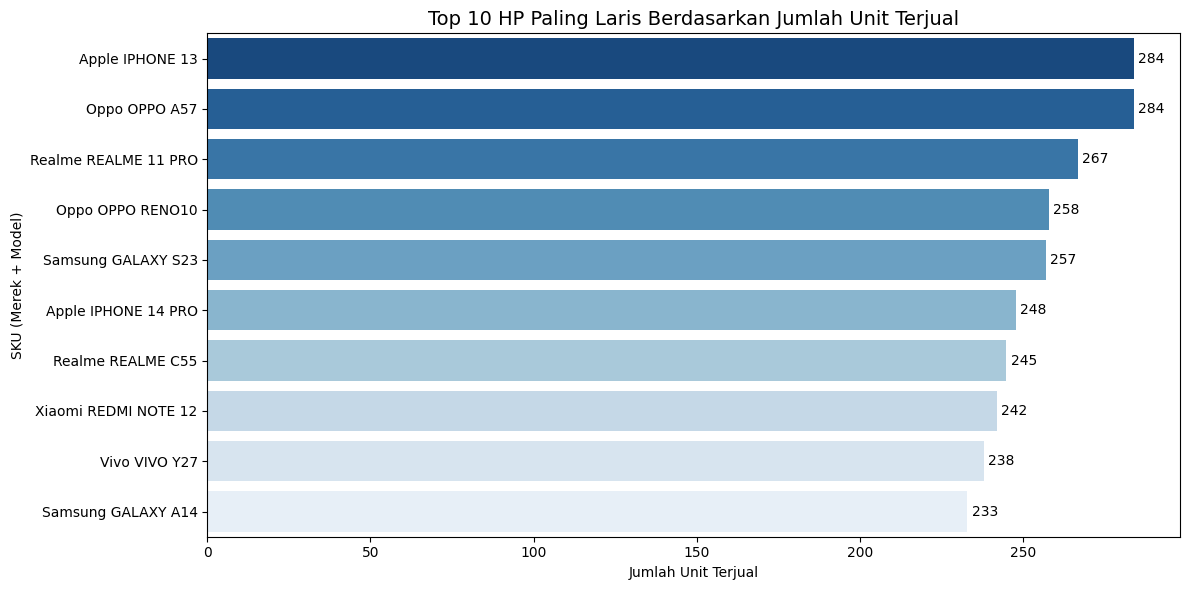

In [21]:
# Visualisasi Top 10 SKU Paling Laris
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=sku_sales.head(10),
    x='total_unit',
    y='sku',
    hue='sku',
    palette='Blues_r',
    dodge=False   # biar hue nggak bikin bar dobel
)

# Tambahkan angka di setiap bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

plt.title("Top 10 HP Paling Laris Berdasarkan Jumlah Unit Terjual", fontsize=14)
plt.xlabel("Jumlah Unit Terjual")
plt.ylabel("SKU (Merek + Model)")
plt.tight_layout()
plt.show()

#Analisis Penjualan per Merek

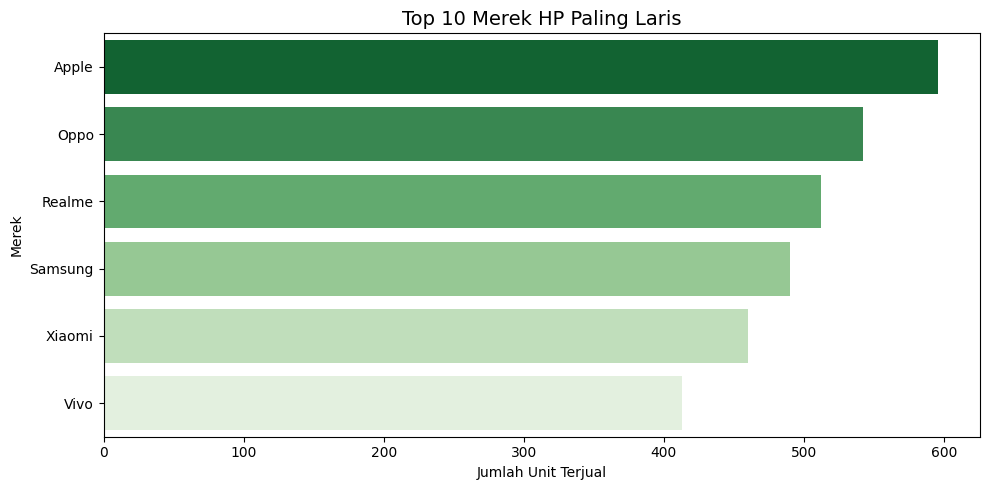

,merek,total_unit,total_revenue
0,Apple,596,6.212921e+09
1,Oppo,542,7.975502e+09
2,Realme,512,1.966830e+09
3,Samsung,490,5.137869e+09
5,Xiaomi,460,5.742486e+09
4,Vivo,413,4.745069e+09


In [100]:
merek_sales = (
    df_eda.groupby('merek', as_index=False)
    .agg(total_unit=('jumlah', 'sum'),
         total_revenue=('total_harga', 'sum'))
    .sort_values(by='total_unit', ascending=False)
)

# Visualisasi Top 10 Merek
plt.figure(figsize=(10,5))
sns.barplot(
    data=merek_sales.head(10),
    x='total_unit',
    y='merek',
    hue='merek',
    palette='Greens_r'
)
plt.title("Top 10 Merek HP Paling Laris", fontsize=14)
plt.xlabel("Jumlah Unit Terjual")
plt.ylabel("Merek")
plt.tight_layout()
plt.show()

merek_sales.head(10)

#Kota mana yang melakukan pembelian terbanyak

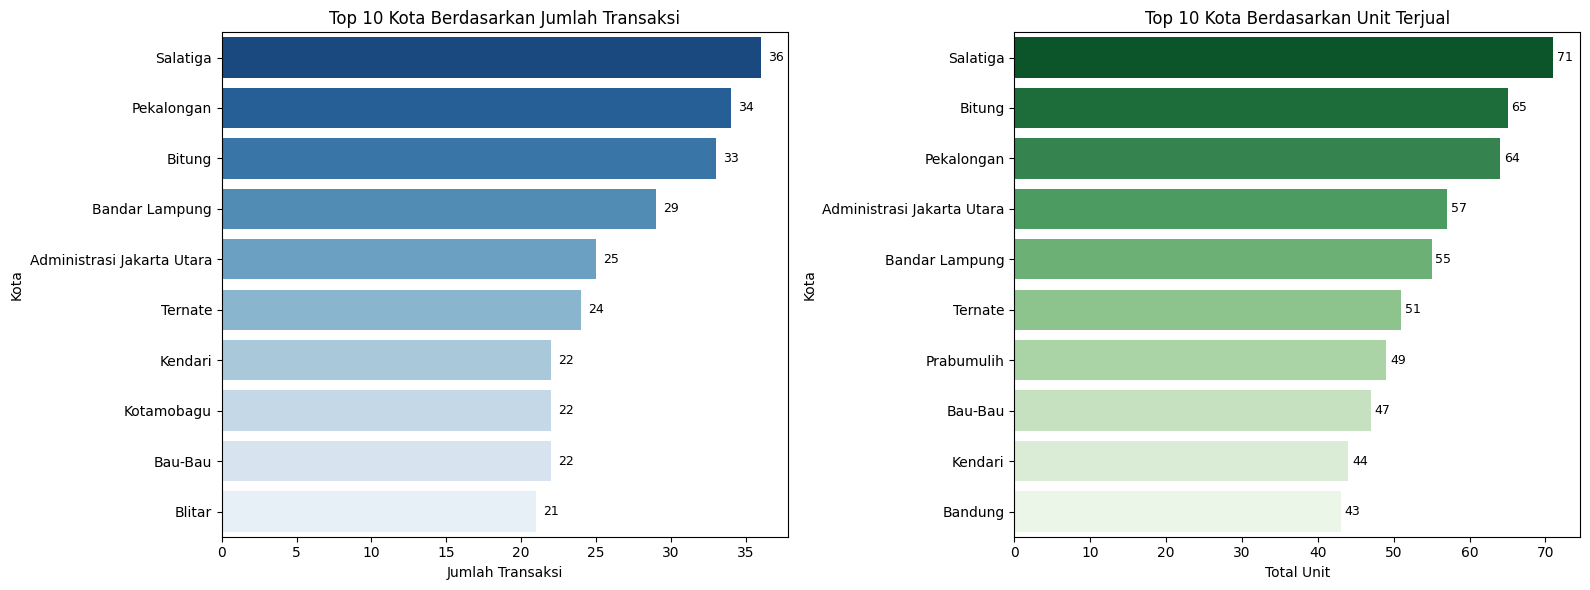

In [31]:
# --- Top 10 Kota by Transaksi ---
top_kota_transaksi = df_eda['kota'].value_counts().reset_index()
top_kota_transaksi.columns = ['kota', 'jumlah_transaksi']

# --- Top 10 Kota by Unit Terjual ---
top_kota_unit = (
    df_eda.groupby('kota', as_index=False)['jumlah'].sum()
    .rename(columns={'jumlah':'total_unit'})
    .sort_values('total_unit', ascending=False)
)

# --- Visualisasi ---
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Barplot jumlah transaksi
sns.barplot(
    data=top_kota_transaksi.head(10),
    x='jumlah_transaksi',
    y='kota',
    hue='kota',           # ✅ perbaikan
    palette='Blues_r',
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Top 10 Kota Berdasarkan Jumlah Transaksi")
axes[0].set_xlabel("Jumlah Transaksi")
axes[0].set_ylabel("Kota")

# Tambahkan angka di batang
for i, v in enumerate(top_kota_transaksi.head(10)['jumlah_transaksi']):
    axes[0].text(v + 0.5, i, str(v), va='center', fontsize=9)

# Barplot unit terjual
sns.barplot(
    data=top_kota_unit.head(10),
    x='total_unit',
    y='kota',
    hue='kota',           # ✅ perbaikan
    palette='Greens_r',
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Top 10 Kota Berdasarkan Unit Terjual")
axes[1].set_xlabel("Total Unit")
axes[1].set_ylabel("Kota")

# Tambahkan angka di batang
for i, v in enumerate(top_kota_unit.head(10)['total_unit']):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Top 10 SKU Terlaris per Kota

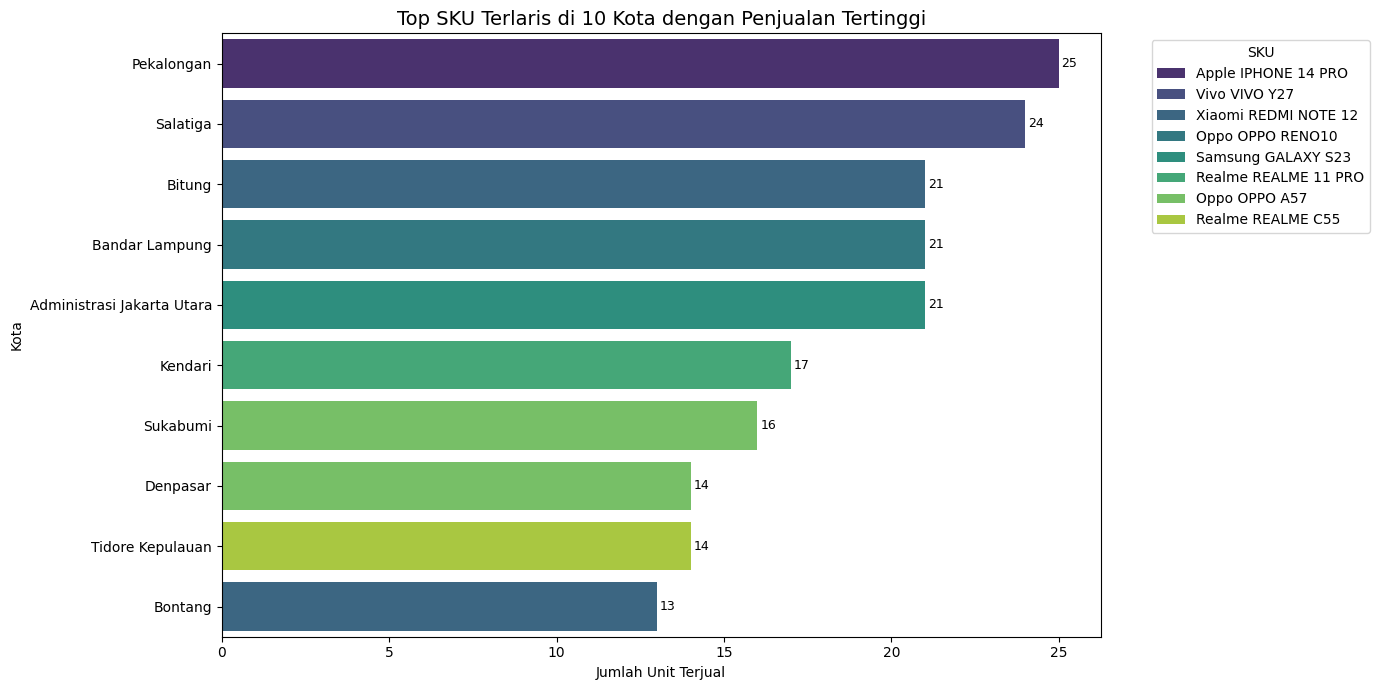

In [37]:
TOP_N_CITIES_VIZ = 10  # Tampilkan hanya 10 kota teratas

plt.figure(figsize=(14, 7))
ax1 = sns.barplot(
    data=top_sku_per_kota.head(TOP_N_CITIES_VIZ),
    x="jumlah",
    y="kota",
    hue="sku",
    palette="viridis"
)
plt.title(f"Top SKU Terlaris di {TOP_N_CITIES_VIZ} Kota dengan Penjualan Tertinggi", fontsize=14)
plt.xlabel("Jumlah Unit Terjual")
plt.ylabel("Kota")
plt.legend(title="SKU", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tambahkan angka di batang
for container in ax1.containers:
    ax1.bar_label(container, fmt="%.0f", label_type="edge", fontsize=9, padding=2)

plt.tight_layout()
plt.show()

# Top 10 Merek Terlaris per Kota

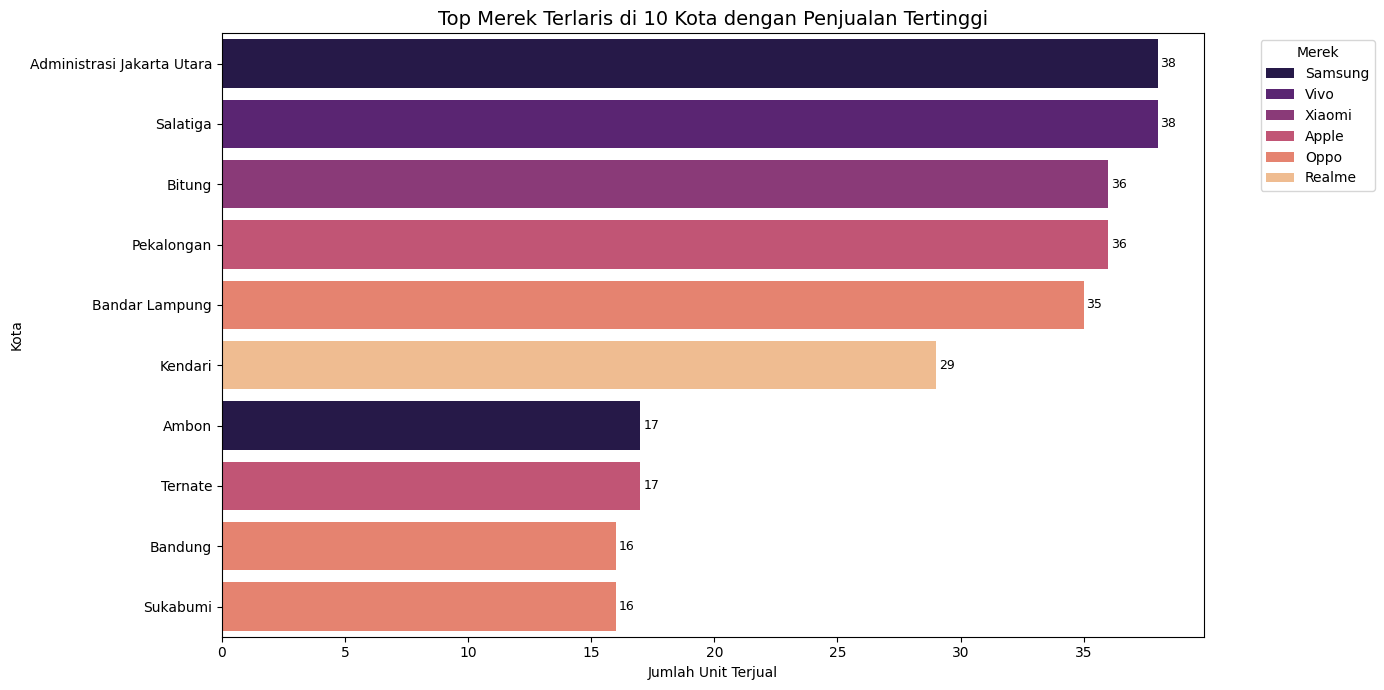

In [38]:
# --- Merek Terlaris per Kota ---
plt.figure(figsize=(14, 7))
ax2 = sns.barplot(
    data=top_brand_per_kota.head(TOP_N_CITIES_VIZ),
    x="jumlah",
    y="kota",
    hue="merek",
    palette="magma"
)
plt.title(f"Top Merek Terlaris di {TOP_N_CITIES_VIZ} Kota dengan Penjualan Tertinggi", fontsize=14)
plt.xlabel("Jumlah Unit Terjual")
plt.ylabel("Kota")
plt.legend(title="Merek", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tambahkan angka di batang
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.0f", label_type="edge", fontsize=9, padding=2)

plt.tight_layout()
plt.show()

# Proporsi Status Pengiriman per Kota (Top 10 Kota dengan Gagal Tertinggi)

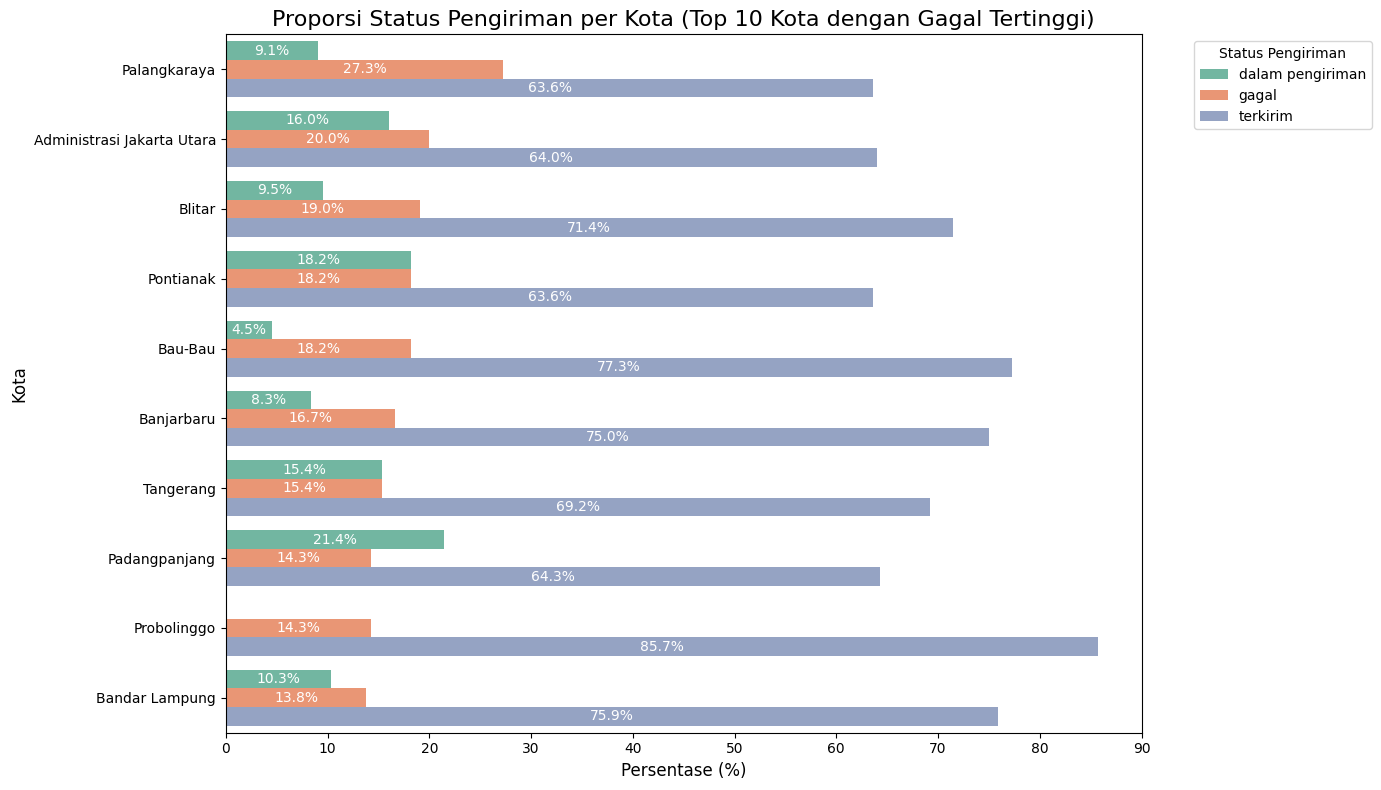

In [49]:
# Ambil 10 kota dengan persentase gagal tertinggi
top_kota = ct['gagal'].sort_values(ascending=False).head(10).index

# Filter crosstab untuk 10 kota saja
ct_top = ct.loc[top_kota].reset_index()

# Ubah dari wide ke long format untuk barplot
ct_plot = pd.melt(ct_top, id_vars="kota", var_name="status_pengiriman", value_name="persentase")

# --- Plot Stacked Bar Chart dengan angka ---
plt.figure(figsize=(14,8))  # Tinggi figure ditingkatkan untuk bar lebih tebal
ax = sns.barplot(
    data=ct_plot,
    x="persentase",
    y="kota",
    hue="status_pengiriman",
    palette="Set2",
    dodge=True  # pastikan bar tidak tumpang tindih
)

plt.title("Proporsi Status Pengiriman per Kota (Top 10 Kota dengan Gagal Tertinggi)", fontsize=16)
plt.xlabel("Persentase (%)", fontsize=12)
plt.ylabel("Kota", fontsize=12)
plt.legend(title="Status Pengiriman", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tambahkan angka di atas tiap bar
for p in ax.patches:
    width = p.get_width()
    if width > 0:  # hanya tampilkan jika ada nilai
        ax.text(
            width/2 + p.get_x(),  # posisi tengah bar
            p.get_y() + p.get_height()/2,
            f'{width:.1f}%',  # format 1 desimal
            ha='center', va='center', fontsize=10, color='white'
        )

plt.tight_layout()
plt.show()

# Top 10 Kota Berdasarkan Jumlah Transaksi

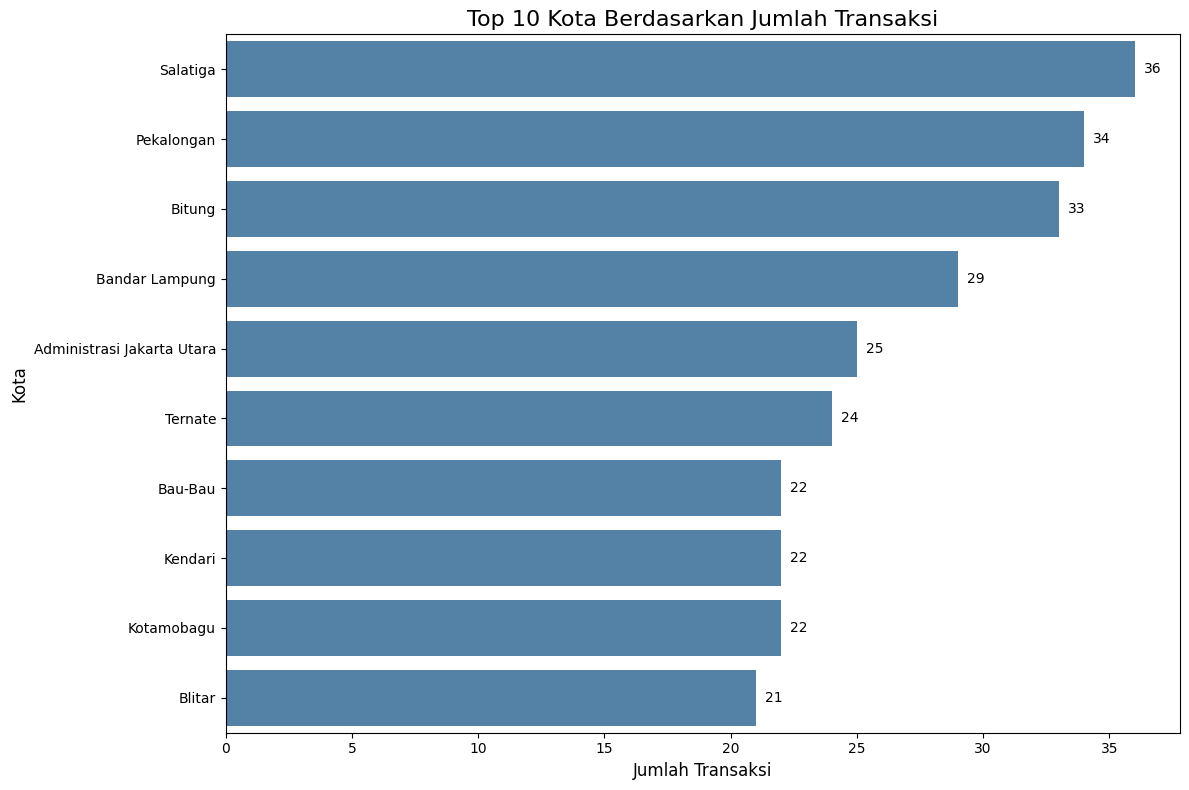

In [58]:
# Ambil top 10 kota berdasarkan jumlah transaksi
top_kota_summary = summary_kota.head(10)

# --- Horizontal Bar Chart dengan angka di setiap bar ---
plt.figure(figsize=(12,8))
ax = sns.barplot(
    data=top_kota_summary,
    y='kota',
    x='jumlah_transaksi',
    color='steelblue'  # ganti palette dengan color tunggal
)

plt.title('Top 10 Kota Berdasarkan Jumlah Transaksi', fontsize=16)
plt.xlabel('Jumlah Transaksi', fontsize=12)
plt.ylabel('Kota', fontsize=12)

# Tambahkan angka di atas setiap bar
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(
            width + max(top_kota_summary['jumlah_transaksi'])*0.01,
            p.get_y() + p.get_height()/2,
            f'{int(width)}',
            ha='left',
            va='center',
            fontsize=10,
            color='black'
        )

plt.tight_layout()
plt.show()

#Merek yang memiliki rating produk tertinggi

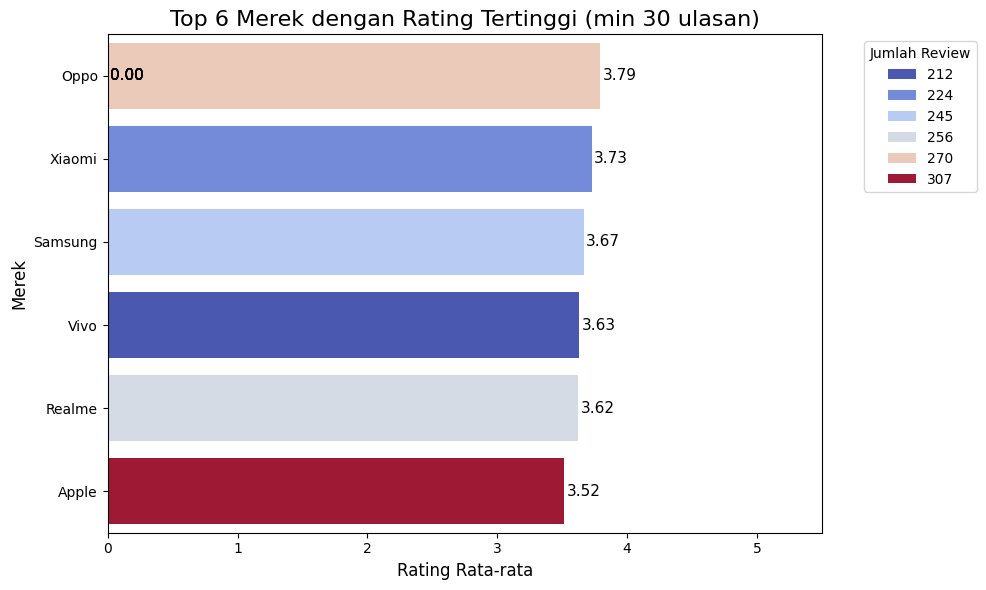

In [77]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=brand_rating_top,
    y='merek',
    x='avg_rating',
    palette=sns.color_palette("coolwarm", as_cmap=True),  # warna kontinu
    hue=brand_rating_top['n_review'],  # warna berdasarkan jumlah review
    dodge=False
)

plt.title(f'Top {top_n} Merek dengan Rating Tertinggi (min {MIN_REVIEWS} ulasan)', fontsize=16)
plt.xlabel('Rating Rata-rata', fontsize=12)
plt.ylabel('Merek', fontsize=12)
plt.legend(title='Jumlah Review', bbox_to_anchor=(1.05,1), loc='upper left')

# Tambahkan angka rating di setiap bar (format 2 desimal saja)
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.02,  # posisi sedikit di luar bar
        p.get_y() + p.get_height()/2,
        f'{width:.2f}',  # 2 desimal saja, hilangkan 00 berlebih
        ha='left', va='center',
        fontsize=11, color='black'
    )

plt.xlim(0, 5.5)
plt.tight_layout()
plt.show()

#Metode pembayaran yang sering digunakan

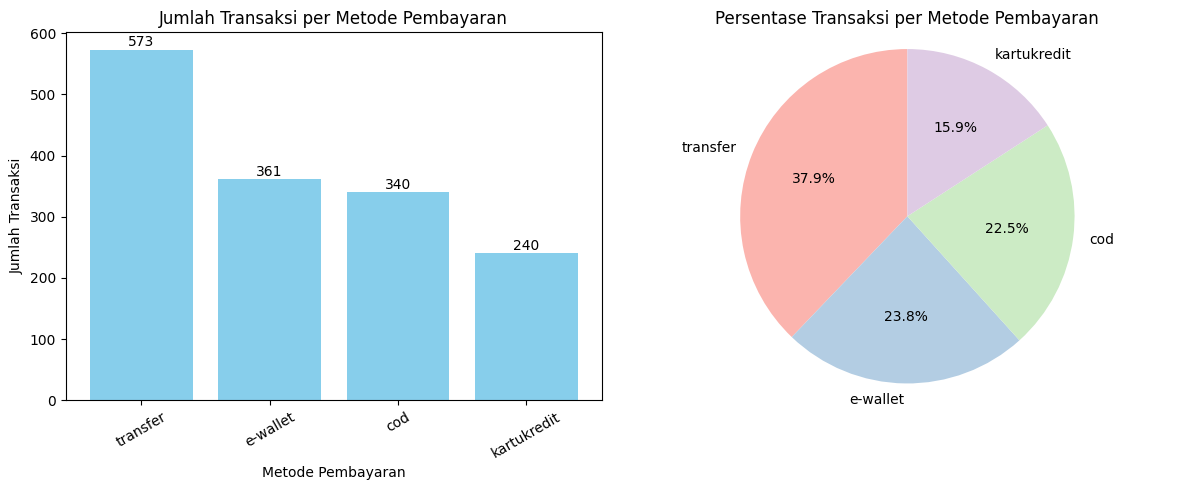

In [83]:
# 13. Metode pembayaran terpopuler (count & proporsi)
pm_count = df_eda['metode_pembayaran'].value_counts(dropna=False).rename_axis('metode_pembayaran').to_frame('jumlah')
pm_count['persentase_%'] = (pm_count['jumlah'] / pm_count['jumlah'].sum() * 100).round(2)

# Visualisasi jumlah transaksi (bar chart)
plt.figure(figsize=(12,5))

# Subplot 1: jumlah transaksi
plt.subplot(1, 2, 1)
bars = plt.bar(pm_count.index.astype(str), pm_count['jumlah'], color='skyblue')
plt.title('Jumlah Transaksi per Metode Pembayaran')
plt.xlabel('Metode Pembayaran')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=30)

# Tambahkan angka di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', ha='center', va='bottom')

# Subplot 2: persentase (pie chart)
plt.subplot(1, 2, 2)
plt.pie(pm_count['persentase_%'], labels=pm_count.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Persentase Transaksi per Metode Pembayaran')
plt.axis('equal')  # supaya pie chart bulat

plt.tight_layout()
plt.show()

#Analisis status pengiriman berdasarkan merek

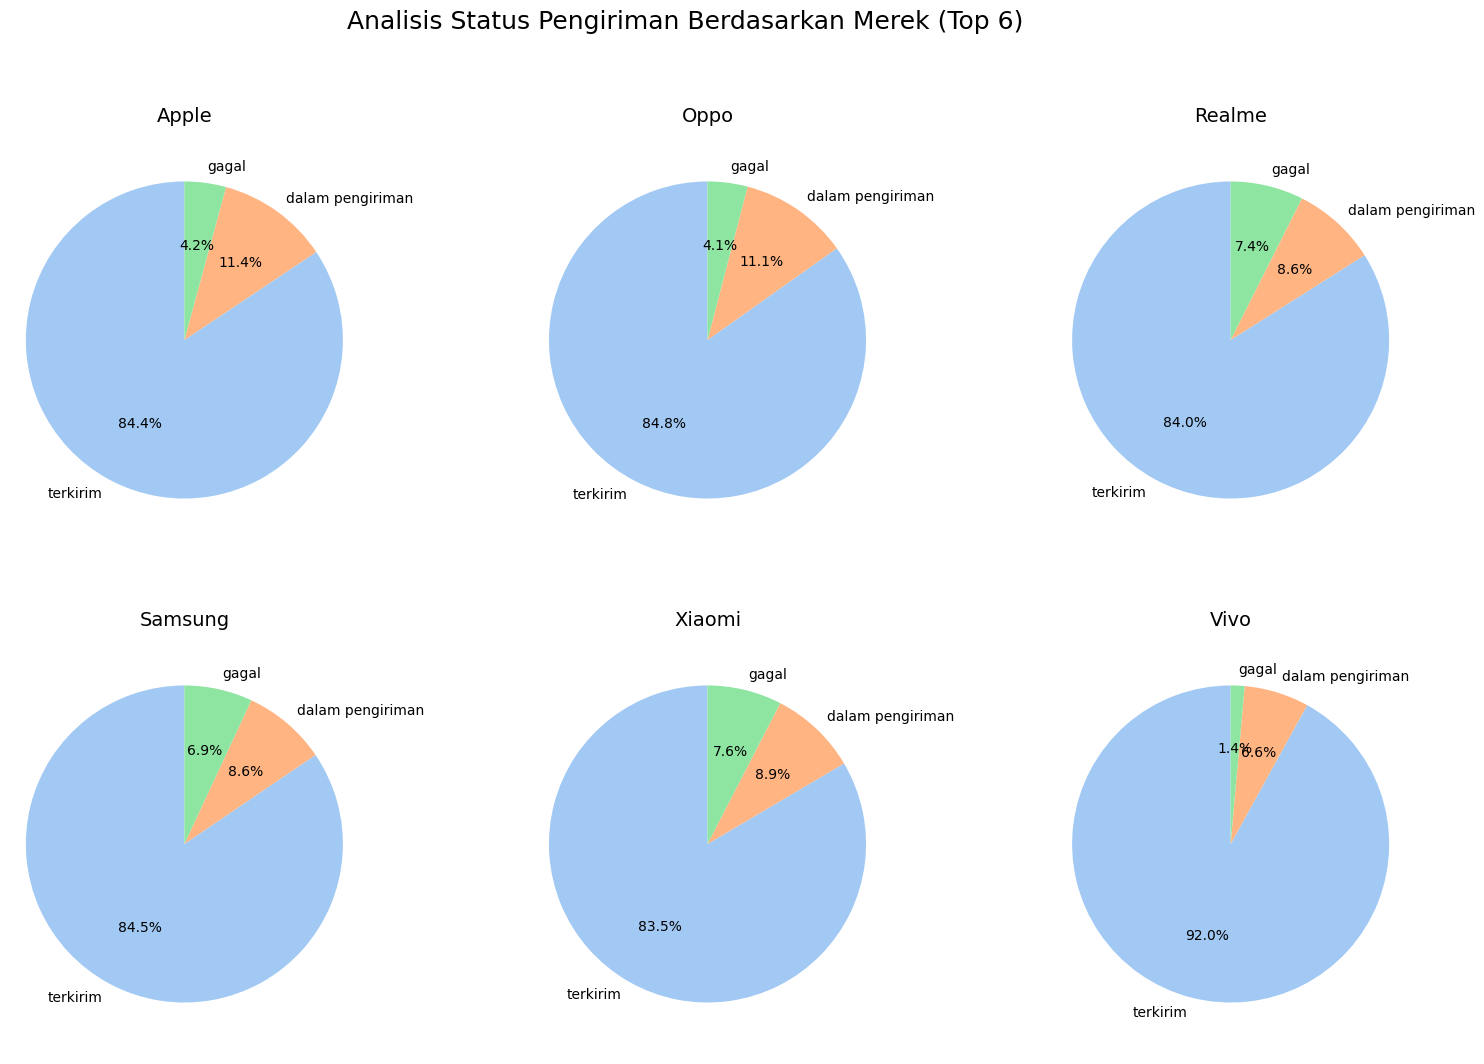

In [89]:
TOP_BRANDS_FOR_PIE = 6
top_brands = df_eda['merek'].value_counts().head(TOP_BRANDS_FOR_PIE).index

# Perbesar figsize agar pie chart lebih besar
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Lebih besar dari 15x10
axes = axes.flatten()

for i, brand in enumerate(top_brands):
    df_brand = df_eda[df_eda['merek'] == brand]
    status_counts = df_brand['status_pengiriman'].value_counts(normalize=True) * 100

    if not status_counts.empty:
        axes[i].pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
                    startangle=90, colors=sns.color_palette('pastel'))
        axes[i].set_title(f'{brand}', fontsize=14)
        axes[i].axis('equal')
    else:
        axes[i].text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
        axes[i].axis('off')

# Judul utama yang lebih deskriptif
plt.suptitle('Analisis Status Pengiriman Berdasarkan Merek (Top 6)', fontsize=18)

# Jarak antar subplots tetap lega
plt.subplots_adjust(wspace=0.5, hspace=0.2)

plt.show()